In [58]:
import os
import random
import pandas as pd
import numpy as np

In [59]:
class Config:
    seed = 42
    test_size = 0.2

In [60]:
def set_all_seeds(seed):
    # python's seeds
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


set_all_seeds(seed=Config.seed)

# Load data

(2337, 10)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1720,z14411100u,Volkswagen ID.4,premium,electro,4.28,2017,114851,2020,58.11,engine_fuel
2025,n-6604555n,VW Polo VI,economy,petrol,5.00,2015,87354,2018,29.21,electro_bug
1430,d-1051262p,Smart ForFour,economy,petrol,4.38,2013,37920,2015,27.19,engine_overheat


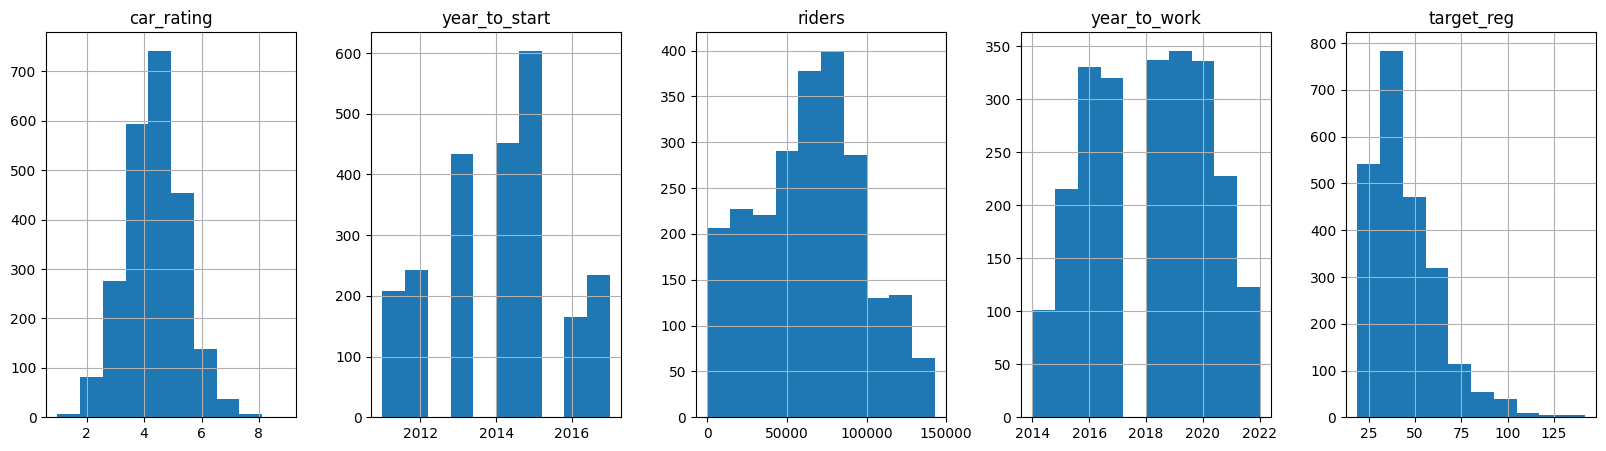

In [61]:
train = pd.read_csv('../data/car_train.csv')
print(train.shape)
train.hist(figsize=(20, 5), layout=(-1, 5))
train.sample(3)

In [62]:
train.describe()

,car_rating,year_to_start,riders,year_to_work,target_reg
count,2337.000000,2337.000000,2337.000000,2337.000000,2337.000000
mean,4.354292,2014.040650,63711.443731,2018.069748,44.946735
std,0.996954,1.685852,33755.012096,2.159484,17.579568
min,0.980000,2011.000000,23.000000,2014.000000,18.920000
25%,3.740000,2013.000000,41053.000000,2016.000000,31.670000
50%,4.360000,2014.000000,64415.000000,2018.000000,40.170000
75%,5.000000,2015.000000,86515.000000,2020.000000,54.790000
max,8.900000,2017.000000,142862.000000,2022.000000,141.630000


(1913, 8)


,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work
49,b-9697936F,Renault Sandero,standart,petrol,4.32,2011,3171,2018
1190,h11115340f,VW Tiguan,economy,petrol,3.60,2017,133516,2021
103,k-7853395L,Kia Rio,economy,petrol,4.82,2015,74448,2021


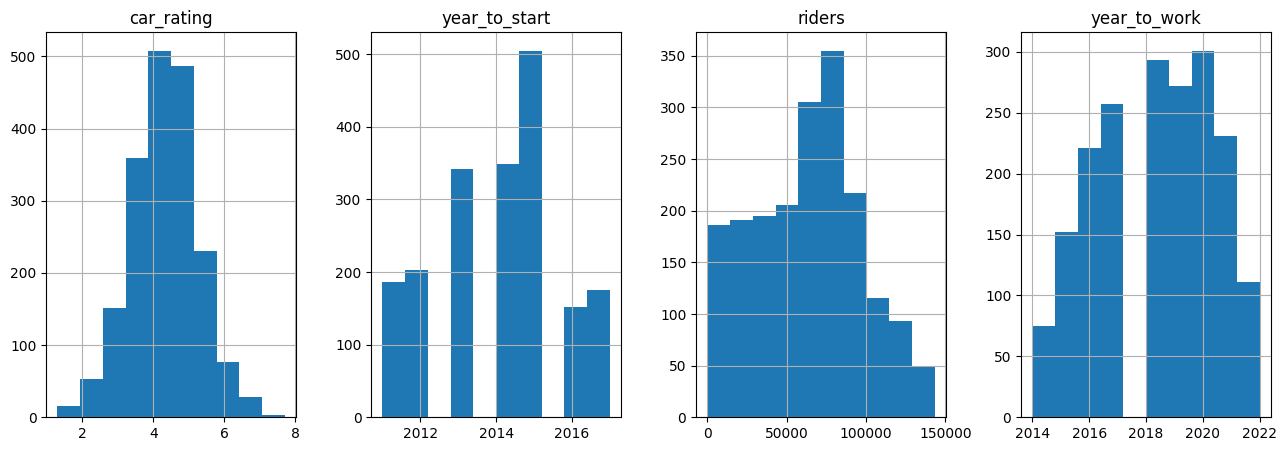

In [83]:
test = pd.read_csv('../data/car_test.csv')
print(test.shape)
test.hist(figsize=(20, 5), layout=(-1, 5))
test.sample(3)

# Get features

In [64]:
features2drop = ['car_id']
targets = ['target_class', 'target_reg']
cat_features = ['car_type', 'fuel_type', 'model']

filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]

print('cat_features :', len(cat_features), cat_features)
print('num_features :', len(num_features), num_features)
print('targets', targets)

cat_features : 3 ['car_type', 'fuel_type', 'model']
num_features : 4 ['car_rating', 'year_to_start', 'riders', 'year_to_work']
targets ['target_class', 'target_reg']


# Catboost v1

In [65]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score  #, mean_squared_error

In [66]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=Config.test_size, random_state=Config.seed)

clf = CatBoostClassifier(cat_features=cat_features)

clf.fit(X_train, y_train,
        eval_set=(X_test, y_test),
        verbose=150, plot=False)

y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 2.1911361	test: 2.1951349	best: 2.1951349 (0)	total: 8.63ms	remaining: 8.62s
150:	learn: 1.6539682	test: 2.2440578	best: 2.1908935 (6)	total: 3.27s	remaining: 18.4s
300:	learn: 1.2455381	test: 2.3306861	best: 2.1908935 (6)	total: 5.2s	remaining: 12.1s
450:	learn: 0.9715368	test: 2.4008990	best: 2.1908935 (6)	total: 6.64s	remaining: 8.08s
600:	learn: 0.7541454	test: 2.4828758	best: 2.1908935 (6)	total: 8.09s	remaining: 5.37s
750:	learn: 0.5871863	test: 2.5655325	best: 2.1908935 (6)	total: 9.53s	remaining: 3.16s
900:	learn: 0.4696383	test: 2.6497783	best: 2.1908935 (6)	total: 11s	remaining: 1.2s
999:	learn: 0.4055238	test: 2.6994979	best: 2.1908935 (6)	total: 11.9s	remaining: 0us

bestTest = 2.19089351
bestIteration = 6

Shrink model to first 7 iterations.

 Accuracy: 0.0876068376068376


In [78]:
tmp = pd.DataFrame(clf.predict(test[filtered_features]))
test['target_class'] = tmp[0]

In [81]:
test.sample(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_class
450,A-6746020J,Smart ForFour,economy,petrol,4.50,2013,40778,2016,engine_check
1128,I50788104J,Renault Sandero,standart,petrol,4.22,2013,37806,2015,engine_overheat
1244,G-6904316x,VW Polo,economy,petrol,5.46,2015,85048,2018,electro_bug


In [82]:
test[['car_id', 'target_class']].to_csv('../submissions/simple_baseline_v1.csv', index=False)

# Get features from rides_info

(739500, 14)


,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
537940,f16556099c,m-1088453g,X1O,2020-02-26,4.56,34,402,51,77.0,1,1625.826919,0,-4.482741,22.933
605355,J21788043E,q92579907V,H1N,2020-01-05,4.58,44,566,49,120.0,0,1994.153929,0,1.770167,8.386
236733,V22388107z,Q14003835G,l1I,2020-02-19,5.02,43,383,37,62.0,1,1075.522313,0,22.146021,21.637


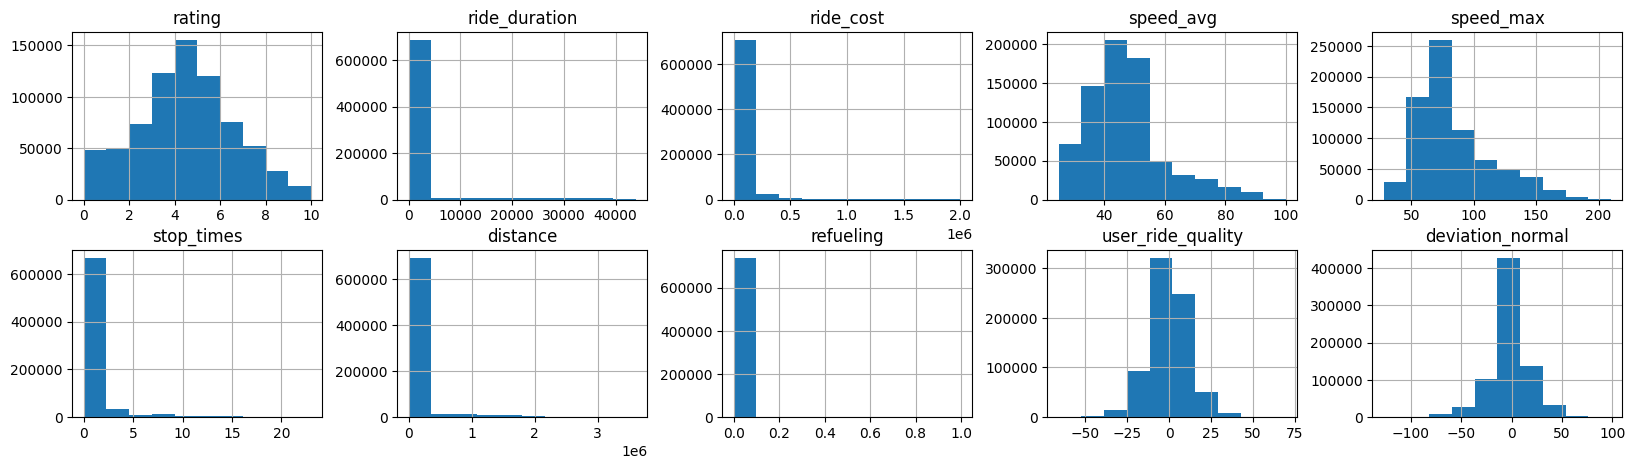

In [84]:
rides = pd.read_csv('../data/rides_info.csv')
print(rides.shape)
rides.hist(figsize=(20, 5), layout=(-1, 5))
rides.sample(3)

In [88]:
f = lambda x: x.nunique()
rides_df_gr = rides.groupby('car_id', as_index=False).agg(mean_rating=('rating', 'mean'),
                                                          distance_sum=('distance', 'sum'),
                                                          rating_min=('rating', 'min'),
                                                          speed_max=('speed_max', 'max'),
                                                          user_ride_quality_median=('user_ride_quality', 'median'),
                                                          deviation_normal_count=('deviation_normal', 'count'),
                                                          user_uniq=('user_id', f))

rides_df_gr.sample(3)

,car_id,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
3752,u-1562836u,4.525230,9.777152e+06,0.1,113.420798,-0.954179,174,169
824,K-2177169P,4.113736,2.047024e+07,0.1,194.690293,-18.339585,174,172
541,G81601770L,3.957184,1.762030e+07,0.0,182.637505,-3.144268,174,173


In [89]:
def add_features(df):

    if 'mean_rating' not in df.columns:
        return df.merge(rides_df_gr, on = 'car_id', how = 'left')

    return df


train = add_features(train)
test = add_features(test)

In [90]:
train.sample(3)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class,mean_rating,distance_sum,rating_min,speed_max,user_ride_quality_median,deviation_normal_count,user_uniq
1380,L73176899o,Smart ForFour,economy,petrol,4.84,2016,102637,2022,68.73,engine_check,4.600747,1.508569e+07,0.1,161.360834,3.445709,174,173
747,b-1380770L,Smart ForTwo,economy,petrol,4.96,2013,47356,2020,30.57,engine_fuel,4.210345,7.769892e+06,0.1,201.348447,-17.370615,174,169
908,R50675613t,Nissan Qashqai,standart,petrol,3.40,2012,23972,2018,33.58,electro_bug,4.181494,2.043258e+07,0.0,189.644927,-11.811154,174,172


In [91]:
train.to_csv('../tmp_data/quickstart_train.csv', index=False)
test.to_csv('../tmp_data/quickstart_tra.csv', index=False)

In [92]:
filtered_features = [i for i in train.columns if (i not in targets and i not in features2drop)]
num_features = [i for i in filtered_features if i not in cat_features]


print('num_features :', len(num_features), num_features)
print('cat_features :', len(cat_features), cat_features)
print('targets', targets)

num_features : 11 ['car_rating', 'year_to_start', 'riders', 'year_to_work', 'mean_rating', 'distance_sum', 'rating_min', 'speed_max', 'user_ride_quality_median', 'deviation_normal_count', 'user_uniq']
cat_features : 3 ['car_type', 'fuel_type', 'model']
targets ['target_class', 'target_reg']


# Catboost v2

In [93]:
X = train[filtered_features].drop(targets, axis=1, errors='ignore')
y = train['target_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = CatBoostClassifier(cat_features=cat_features)


clf.fit(X_train, y_train,
          eval_set=(X_test, y_test),
          verbose=150, plot=False)

y_pred = clf.predict(X_test)
print(f'\n Accuracy: {accuracy_score(y_test, y_pred)}')

Learning rate set to 0.109335
0:	learn: 1.8475119	test: 1.8655808	best: 1.8655808 (0)	total: 13.4ms	remaining: 13.3s
150:	learn: 0.3200590	test: 0.5547029	best: 0.5540463 (147)	total: 4.26s	remaining: 23.9s
300:	learn: 0.1971982	test: 0.5615205	best: 0.5513186 (167)	total: 6.1s	remaining: 14.2s
450:	learn: 0.1361985	test: 0.5694143	best: 0.5513186 (167)	total: 7.93s	remaining: 9.66s
600:	learn: 0.0986190	test: 0.5871706	best: 0.5513186 (167)	total: 9.73s	remaining: 6.46s
750:	learn: 0.0741270	test: 0.6001668	best: 0.5513186 (167)	total: 11.5s	remaining: 3.82s
900:	learn: 0.0588730	test: 0.6157155	best: 0.5513186 (167)	total: 13.4s	remaining: 1.47s
999:	learn: 0.0514613	test: 0.6249407	best: 0.5513186 (167)	total: 14.5s	remaining: 0us

bestTest = 0.5513186112
bestIteration = 167

Shrink model to first 168 iterations.

 Accuracy: 0.782051282051282


In [94]:
fi = clf.get_feature_importance(prettified=True)
fi

,Feature Id,Importances
0,speed_max,36.034645
1,mean_rating,30.903684
2,rating_min,13.938537
3,model,4.206258
4,car_type,3.881288
5,user_uniq,3.035950
6,user_ride_quality_median,2.097702
7,distance_sum,1.614279
8,riders,1.347984
9,car_rating,1.149331


In [96]:
test['target_class'] = pd.DataFrame(clf.predict(test[filtered_features]))

In [98]:
test[['car_id', 'target_class']].to_csv('../submissions/simple_baseline_v2.csv', index=False)